<a href="https://colab.research.google.com/github/anniebritton/Eco-Drought-South-Dakota/blob/main/NDVI_Data_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Colab Set Up**

In [ ]:
# installs and import libraries
!pip install geopandas 
!pip install matplotlib
!pip install scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
plt.rcParams["figure.figsize"] = (20,3)

In [ ]:
# mount gogole drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Import Data**

In [ ]:
# import the dataset only for the full range of NDVI data 2000 on
df_ndvi = pd.read_csv('/content/drive/MyDrive/School/M.S./Courses/Capstone/Colab/Data/CSVs/drought_NDVI_range_V2.csv')
df_ndvi['date'] = pd.to_datetime(df_ndvi['date']).dt.strftime('%Y-%m-%d')
df_ndvi['date'] = pd.to_datetime(df_ndvi['date'])
df_ndvi = df_ndvi.set_index('date')
# df_ndvi = df_ndvi.drop(['smam', 'smpm', 'PP_NDVI'], axis=1)

In [ ]:
# import and create a list of pentads that the drought data is based on. 
# This will be used to calculate anomalies and average so that all of the 
# data variables match temporally
pentads = pd.read_csv('/content/drive/MyDrive/School/M.S./Courses/Capstone/Colab/Data/CSVs/drought_variable_pentads.csv')
pentads = pentads[1470:]
pentads = pentads['date'].tolist()

**Calculate Anomalies**

In [ ]:
# Function that will calculate the daily mean for each variable and then 
# subsequently calculate the anomaly for each variable/day
def calculate_anomaly(df, value_col):
    
    # Group the data by day of the year and calculate the average for each day of the year
    df_daily_grouping = df.groupby(df.index.dayofyear).mean()

    # Create a dictionary mapping day of year to average value
    day_of_year_to_mean = df_daily_grouping[value_col].to_dict()

    # Map the day of year to the average value for that day of year
    df['day_of_year'] = df.index.dayofyear
    df[f'day_of_year_{value_col}_mean'] = df['day_of_year'].map(day_of_year_to_mean)

    # Calculate the daily anomaly as the difference between the original value and the average value for that day of year
    df[f'{value_col}_anomaly'] = df[value_col] - df[f'day_of_year_{value_col}_mean']

# NOTE - I am doing this before resampling we want to look at each day of the year here.
# If we did this after resampling, because of the way the pentads work, we would have
# less data to compare year to year.

# Apply the function to each column of the dataframe
for col in df_ndvi.columns:
    if col != 'date':
        calculate_anomaly(df_ndvi, col)

In [ ]:
# Reduce the dataframe so that it only contains the anomaly data
df_anom = df_ndvi[df_ndvi.columns[df_ndvi.columns.str.endswith('_anomaly')]]

# Move the NDVI column to the first position in the dataframe
df_anom.insert(0, 'NDVI_anomaly', df_anom.pop('NDVI_anomaly'))

**Resample the Data to match the Pentads from the Drought Indexes, and Normalize**

In [ ]:
# THIS NARROWS THE DATA DOWN TO PENTADS - only have data every 5 days
# create an empty list to store the result dataframes
results = []

# loop through each column in the dataframe
for col in df_anom.columns:
    if col == 'NDVI_anomaly':
        result = pd.DataFrame({'date': pentads, f'{col}_roll': df_anom[col].rolling(window=30, min_periods=1).mean().loc[pentads]})
    else:
        result = pd.DataFrame({'date': pentads, f'{col}_roll': df_anom[col].rolling(window=30, min_periods=1).mean().loc[pentads]})
    result = result.set_index('date')
    results.append(result)

# concatenate the result dataframes into a single dataframe
anom_result = pd.concat(results, axis=1)

# remove the first row since that row is not based on a 5-day average
anom_result = anom_result[1:]

# normalize the data
normalized_df = (anom_result-anom_result.mean())/anom_result.std()

**~ Visualize ~**

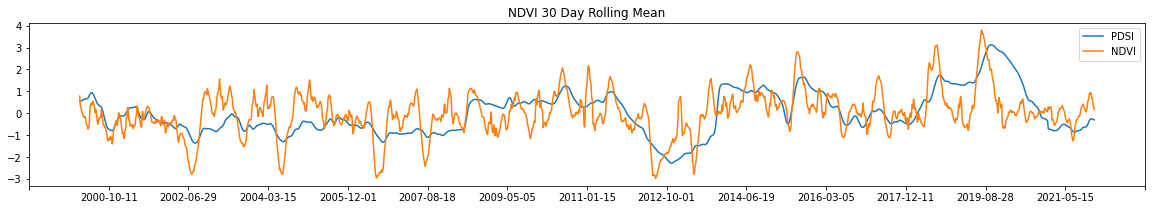

In [ ]:
b = normalized_df['pdsi_anomaly_roll']
c = normalized_df['NDVI_anomaly_roll']
fig, ax = plt.subplots(1,1, )
ax.plot(b, label='PDSI')
ax.plot(c, label='NDVI')
ax.xaxis.set_major_locator(ticker.LinearLocator(numticks = 15))
ax.legend()
plt.title("NDVI 30 Day Rolling Mean")
fig.show()

**Prelim ML Tests**

In [ ]:
# add in a boolean drought column (1 for drought, 0 for no drought)
normalized_df['drought_bool'] = np.where(normalized_df["pdsi_anomaly_roll"] >= 0, 0, 1)

In [ ]:
# try a random forest classifier
from sklearn.ensemble import RandomForestClassifier

X = normalized_df.iloc[:,0:15].values
Y = normalized_df.iloc[:,15:16].values.ravel()

clf = RandomForestClassifier(n_estimators=100)

# SUBSET YOUR X AND Y INTO TRAIN/TEST SETS; for instance, take first 80% of the rows as training, last 20% as test
X_train = normalized_df.iloc[0:1272, 0:15].values
Y_train = normalized_df.iloc[0:1272, 15:16].values.ravel()
X_test = normalized_df.iloc[1272:1590, 0:15].values
Y_test = normalized_df.iloc[1272:1590, 15:16].values

clf.fit(X_train, Y_train)
Y_predicted = clf.predict(X_test)

In [ ]:
# compare Y_predicted with Y_test
clf.score(X_test, Y_test)

1.0

In [ ]:
# try a decision tree regressor
from sklearn import tree

X = normalized_df.iloc[:,1:15].values
Y = normalized_df.iloc[:,0:1].values.ravel()

clf = tree.DecisionTreeRegressor()

X_train = normalized_df.iloc[0:1272, 1:15].values
Y_train = normalized_df.iloc[0:1272, 0:1].values.ravel()
X_test = normalized_df.iloc[1272:1590, 1:15].values
Y_test = normalized_df.iloc[1272:1590, 0:1].values

clf.fit(X_train, Y_train)
Y_predicted = clf.predict(X_test)

In [ ]:
# compare Y_predicted with Y_test
clf.score(X_test, Y_test)

0.12142816339524898

In [ ]:
# try support vector regression
from sklearn import svm

X = normalized_df.iloc[:,1:15].values
Y = normalized_df.iloc[:,0:1].values.ravel()

regr = svm.SVR()

X_train = normalized_df.iloc[0:1272, 1:15].values
Y_train = normalized_df.iloc[0:1272, 0:1].values.ravel()
X_test = normalized_df.iloc[1272:1590, 1:15].values
Y_test = normalized_df.iloc[1272:1590, 0:1].values

regr.fit(X_train, Y_train)
Y_predicted = regr.predict(X_test)

In [ ]:
# compare Y_predicted with Y_test
regr.score(X_test, Y_test)

0.26569359098678746